# Custom YOLOv5 for Car Detection

**Copyright (C) 2024 Francisco Lopez**

This program is free software: you can redistribute it and/or modify  
it under the terms of the GNU General Public License as published by  
the Free Software Foundation, either version 3 of the License, or  
(at your option) any later version.

This program is distributed in the hope that it will be useful,  
but WITHOUT ANY WARRANTY; without even the implied warranty of  
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the  
GNU General Public License for more details.

You should have received a copy of the GNU General Public License  
along with this program. If not, see [https://www.gnu.org/licenses/](https://www.gnu.org/licenses/).

### Acknowledgments:
- **YOLOv5**: Licensed under [AGPL-3.0](https://github.com/ultralytics/yolov5).
- **COCO Dataset**: Licensed under [CC BY 4.0](https://cocodataset.org/).


# Object Detection with YOLOv5: Transfer Learning Using Coco Dataset ( Filtered for cars )
This project focuses on building an object detection model using YOLOv5 to detect cars in images. This notebook demonstrates the progress made, including:
- Dataset preparation
- Model training on a custom dataset
- Preliminary results

# Object Detection with YOLOv5 Using a Custom Dataset

### 1. Introduction 
- Brief overview of the project.  
  - **Objective:** Train a YOLOv5 model to detect cars using a subset of the COCO dataset.  
  - **Goal:** Deploy a web application for real-time object detection.
- Tool & Technologies:  
    - **Framework:** PyTorch, YOLOv5  
    - **Platform:** AWS SageMaker
Dataset: COCO (filtered for car class)

### 2. Progress Overview
- Dataset Preparation
  - The COCO datset was filtered to include only images labeled with the "car" class
  - Coco annotations were converted to YOLO format using a python script with multi-core processing to optimize the conversion process
  - Validation and training datasets were orginzied inot the apporopriate folder structure required for YOLOv5
- Model Training:
  - A pre-trained YOLOv5 model was fine0tuned on the car-only subset of COCO dataset
  - Transfer learning was used by frezzing the backbone layers and training only the detection head for 5-10 epochs
  - Traning log and results, such as lass values and visualizations of bounding boxes, have been generated to monitor progress
- Setup for Deployment
  - Sagemaker studio has been used for trainning and managing the model pipline
  - The trained model weights will be saved as best.pt, ready to be used in the web application

### 3. Next Steps
- Model Evaluation:
  - Evaluate the trained model's performace using metrics like percision, recall, and mAP
- Web Application development:
  - Backend: Use of an API endpoint for running inference with the trained YOLOv5 model
  - Frontend: Use React for the user interface, allowing users to upload images and or videos and vizualize predictions
  - Integration: Connect the backend model to the front end, enabling seamless interactions
- Deployment:
  - Deploy the web app to AWS using SageMaker Endpoints for inference or and EC2 instance with GPU support

### Please Note: This is an initial training run, intended as a practice to ensure the process works smoothly and everything is set up correctly. It is not the final training iteration.

In [6]:
# Imports
import os
import matplotlib.pyplot as plt
from PIL import Image

In [7]:
# Paths
weights_path = "../yolov5/runs/train/exp8/weights/best.pt"  # Path to the best weights
val_images_dir = "../data/coco/images/val2017"   # Directory containing validation images
output_dir = "runs/detect"                       # Output directory for inference results
os.makedirs(output_dir, exist_ok=True)


### Running Inference on Images
This section demonstrates how the trained YOLOv5 model is used for inference, generating predictions on new images.

1. **Inference on Validation Images**:
   - These are labeled images from the validation set (`val2017`), which were held out during training.
   - Running inference on these images allows us to evaluate the model's performance and calculate metrics like precision, recall, and mAP (mean Average Precision).

2. **Inference on Test Images**:
   - These are images from the test set (`test2017`), typically used for demonstrating how the model performs on unseen data.
   - Since the test set is unlabeled in many datasets like COCO, the output includes predictions such as bounding boxes, class labels, and confidence scores for detected objects.

Each cell below will:
- Specify the paths for the trained model weights, the image directory (`val2017` or `test2017`), and the output directory for the inference results.
- Run the YOLOv5 model's detection script to generate predictions for the specified dataset.
- Save the results (e.g., annotated images with bounding boxes) in the `runs/detect/val_results` or `runs/detect/test_results` directory.


If there is an error while running this please make sure to run these commands
`sudo apt-get update`
`sudo apt-get install -y  libgl1-mesa-glx`
`pip install opencv-python-headless`

In [8]:
# Inference on Validation Images
# Define correct paths for val inference
weights_path = "yolov5/runs/train/exp8/weights/best.pt"  # Path to trained weights
val_images_dir = "data/coco/images/val2017"             # Path to validation images

# Run inference on validation images
!python yolov5/detect.py --weights {weights_path} --img 640 --conf 0.25 --source {val_images_dir} --project yolov5/runs/detect --name val_results --exist-ok


detect: weights=['yolov5/runs/train/exp8/weights/best.pt'], source=data/coco/images/val2017, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=val_results, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-383-g1435a8ee Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/5000 /home/sagemaker-user/data/coco/images/val2017/000000000139.jpg: 448x640 (no detections), 40.0ms
image 2/5000 /home/sagemaker-user/data/coco/images/val2017/000000000285.jpg: 640x608 (no detections), 39.9ms
image 3/5000 /home/sagemaker-user/data/coco/images/val2017/0

In [13]:
import os
import shutil
from pathlib import Path

# Paths
test_images_dir = "data/coco/images/test2017/test2017"  # Path to test images
subset_dir = "data/coco/images/test2017_subset"  # Temporary directory for subset

# Ensure the subset directory exists
os.makedirs(subset_dir, exist_ok=True)

# Get all test images
test_images = list(Path(test_images_dir).glob("*.jpg"))

# Select 1,500 images (or fewer if less are available)
subset_images = test_images[:1500]

# Copy the selected images to the subset directory
for img_path in subset_images:
    shutil.copy(img_path, subset_dir)

# Define paths for inference
weights_path = "yolov5/runs/train/exp8/weights/best.pt"  # Path to trained weights
subset_images_dir = subset_dir  # Subset directory

# Run inference on subset
!python yolov5/detect.py --weights {weights_path} --img 640 --conf 0.25 --source {subset_images_dir} --project yolov5/runs/detect --name test_results_subset --exist-ok


detect: weights=['yolov5/runs/train/exp8/weights/best.pt'], source=data/coco/images/test2017_subset, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=test_results_subset, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-383-g1435a8ee Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/1500 /home/sagemaker-user/data/coco/images/test2017_subset/000000000016.jpg: 640x480 (no detections), 38.1ms
image 2/1500 /home/sagemaker-user/data/coco/images/test2017_subset/000000000161.jpg: 480x640 (no detections), 39.2ms
image 3/1500 /home/sagemaker

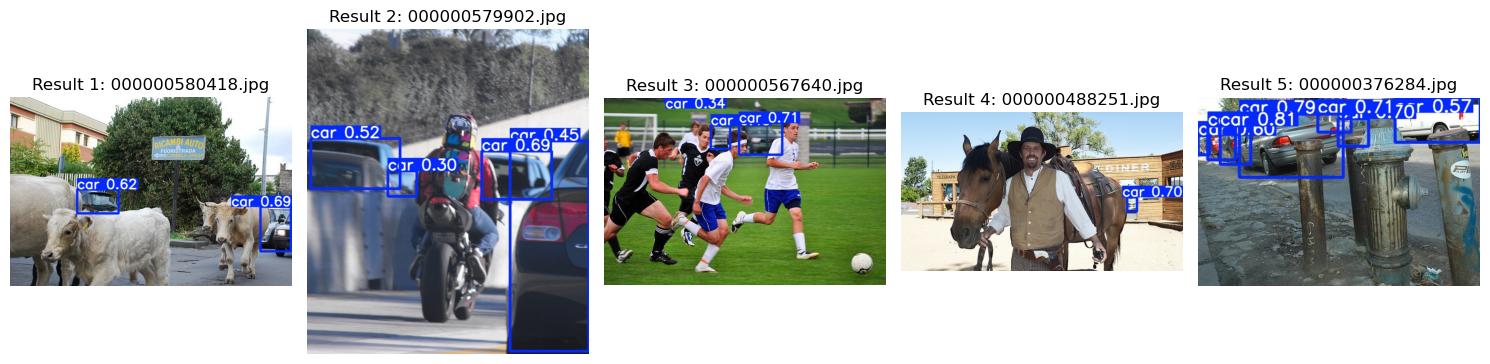

In [9]:

# Define the output directory
output_images_dir = "yolov5/runs/detect/val_results"

# List of specific image filenames to display
specific_images = ["000000580418.jpg", "000000579902.jpg", "000000567640.jpg", "000000488251.jpg", "000000376284.jpg"]  # Replace with your filenames

# Ensure the output directory exists
if os.path.exists(output_images_dir):
    # Check if the specific images exist in the directory
    existing_images = [img for img in specific_images if os.path.exists(os.path.join(output_images_dir, img))]

    if existing_images:
        # Display the specific images
        plt.figure(figsize=(15, 10))
        for i, img_name in enumerate(existing_images):
            img_path = os.path.join(output_images_dir, img_name)
            img = Image.open(img_path)
            plt.subplot(1, len(existing_images), i + 1)
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"Result {i+1}: {img_name}")
        plt.tight_layout()
        plt.show()
    else:
        print("No specified images found in the output directory.")
else:
    print(f"Output directory '{output_images_dir}' does not exist. Please check the path.")


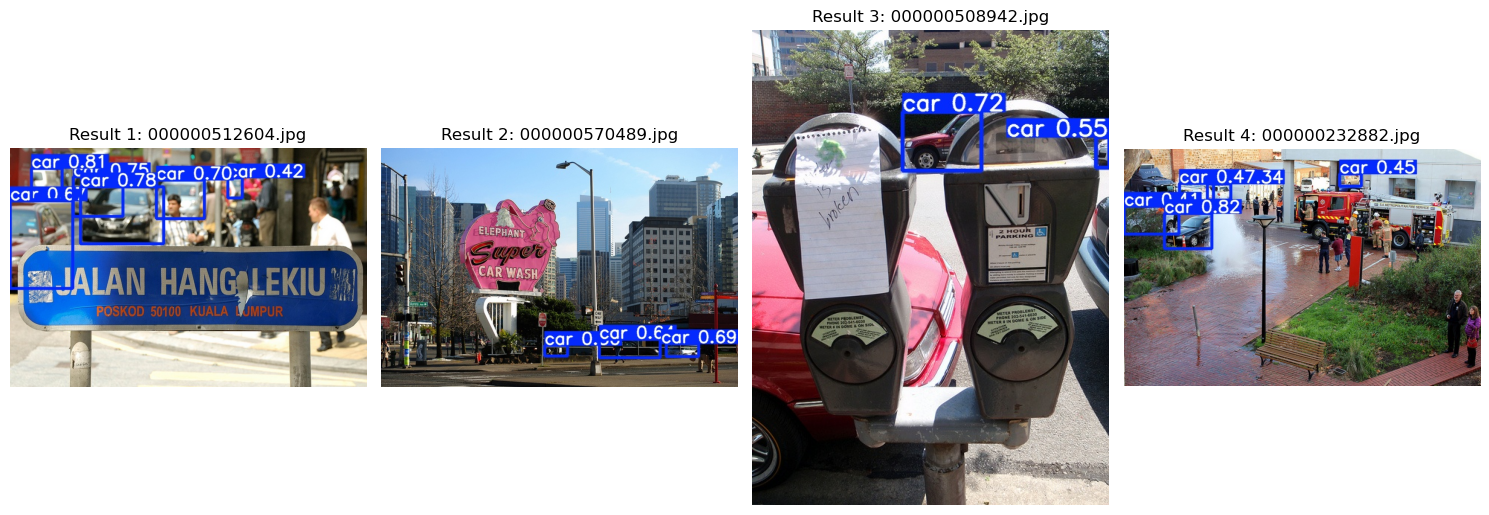

In [14]:

# Define the output directory
output_images_dir = "yolov5/runs/detect/test_results_subset"

# List of specific image filenames to display
specific_images = ["000000512604.jpg", "000000570489.jpg", "000000567640.jpg", "000000508942.jpg", "000000232882.jpg"]  # Replace with your filenames

# Ensure the output directory exists
if os.path.exists(output_images_dir):
    # Check if the specific images exist in the directory
    existing_images = [img for img in specific_images if os.path.exists(os.path.join(output_images_dir, img))]

    if existing_images:
        # Display the specific images
        plt.figure(figsize=(15, 10))
        for i, img_name in enumerate(existing_images):
            img_path = os.path.join(output_images_dir, img_name)
            img = Image.open(img_path)
            plt.subplot(1, len(existing_images), i + 1)
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"Result {i+1}: {img_name}")
        plt.tight_layout()
        plt.show()
    else:
        print("No specified images found in the output directory.")
else:
    print(f"Output directory '{output_images_dir}' does not exist. Please check the path.")


### Confusion Matrix
The confusion matrix visualizes the performance of the model on the validation dataset by comparing predicted and actual classes. Each cell shows the number of predictions for a particular class compared to the true class. The diagonal represents correct predictions.


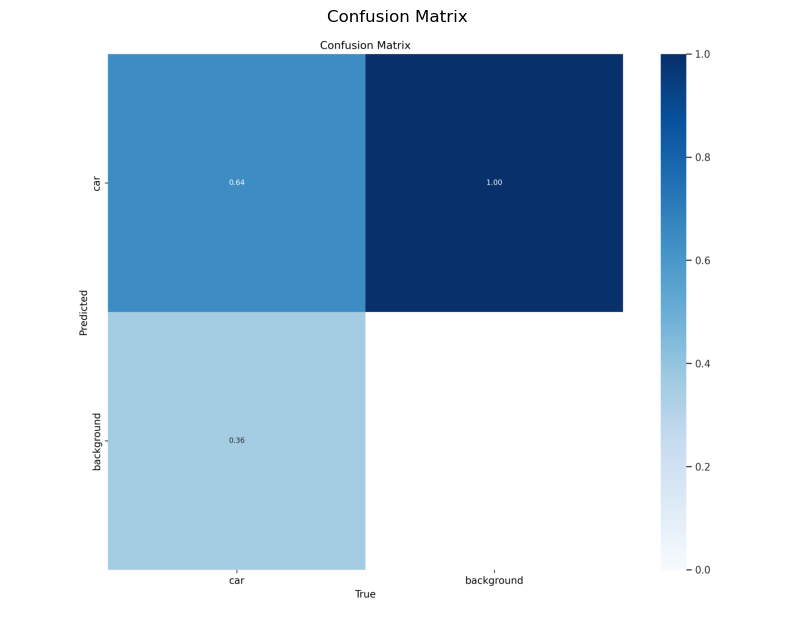

In [11]:
# Path to the confusion matrix image
confusion_matrix_path = "yolov5/runs/train/exp8/confusion_matrix.png"  # Update the path if needed

# Load and display the image
img = Image.open(confusion_matrix_path)

plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis("off")  # Turn off axes for better visualization
plt.title("Confusion Matrix")
plt.show()


In [ ]:
python train.py --img 640 --batch 32 --epochs 2 --data coco_car.yaml --weights yolov5s.pt --freeze 10

### Precision-Recall Curve
The Precision-Recall (PR) curve shows the tradeoff between precision and recall for different confidence thresholds. It helps to evaluate how well the model balances false positives and false negatives.


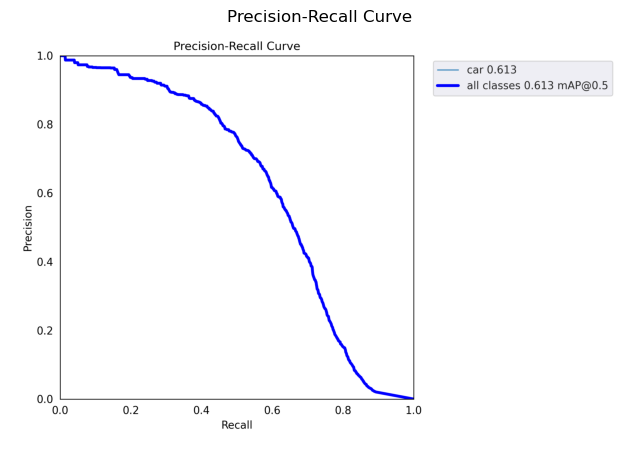

In [19]:
# Display Precision-Recall Curve
pr_curve_path = "yolov5/runs/train/exp8/PR_curve.png"
img = Image.open(pr_curve_path)

plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')
plt.title("Precision-Recall Curve")
plt.show()


### F1 Score Curve
The F1 score is the harmonic mean of precision and recall. This curve shows the F1 score at different confidence thresholds, indicating the model's overall balance between precision and recall.


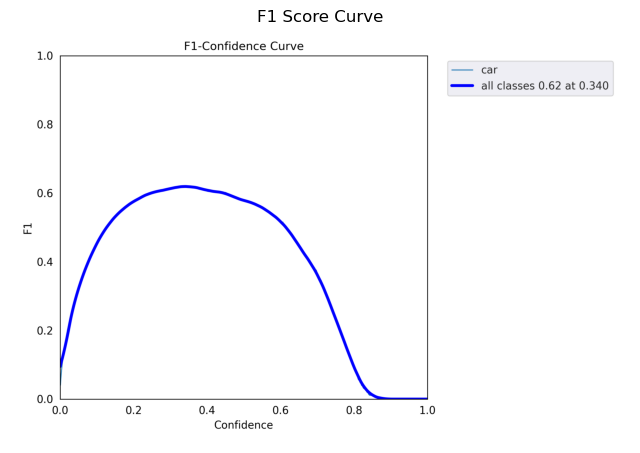

In [20]:
# Display F1 Score Curve
f1_curve_path = "yolov5/runs/train/exp8/F1_curve.png"
img = Image.open(f1_curve_path)

plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')
plt.title("F1 Score Curve")
plt.show()


### Training Metrics Over Epochs
The following graph shows the training metrics such as precision, recall, mAP@50, and mAP@50-95 over the training epochs, providing insight into the model's learning progress.


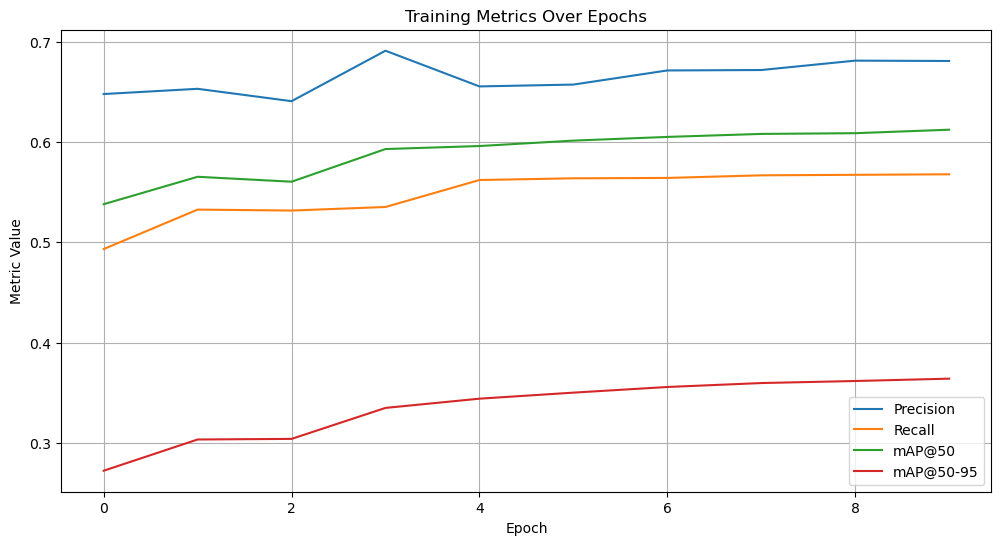

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Path to your results.csv file
results_csv_path = "yolov5/runs/train/exp8/results.csv"

# Load training results and clean column names
results = pd.read_csv(results_csv_path)
results.columns = [col.strip() for col in results.columns]  # Strip extra spaces

# Plot training metrics
plt.figure(figsize=(12, 6))
plt.plot(results["epoch"], results["metrics/precision"], label="Precision")
plt.plot(results["epoch"], results["metrics/recall"], label="Recall")
plt.plot(results["epoch"], results["metrics/mAP_0.5"], label="mAP@50")
plt.plot(results["epoch"], results["metrics/mAP_0.5:0.95"], label="mAP@50-95")

plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.title("Training Metrics Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


### Training and Validation Predictions
The following images display examples of predictions during training and validation. These visualizations help assess the model's performance qualitatively by showing bounding boxes and confidence scores on the images.


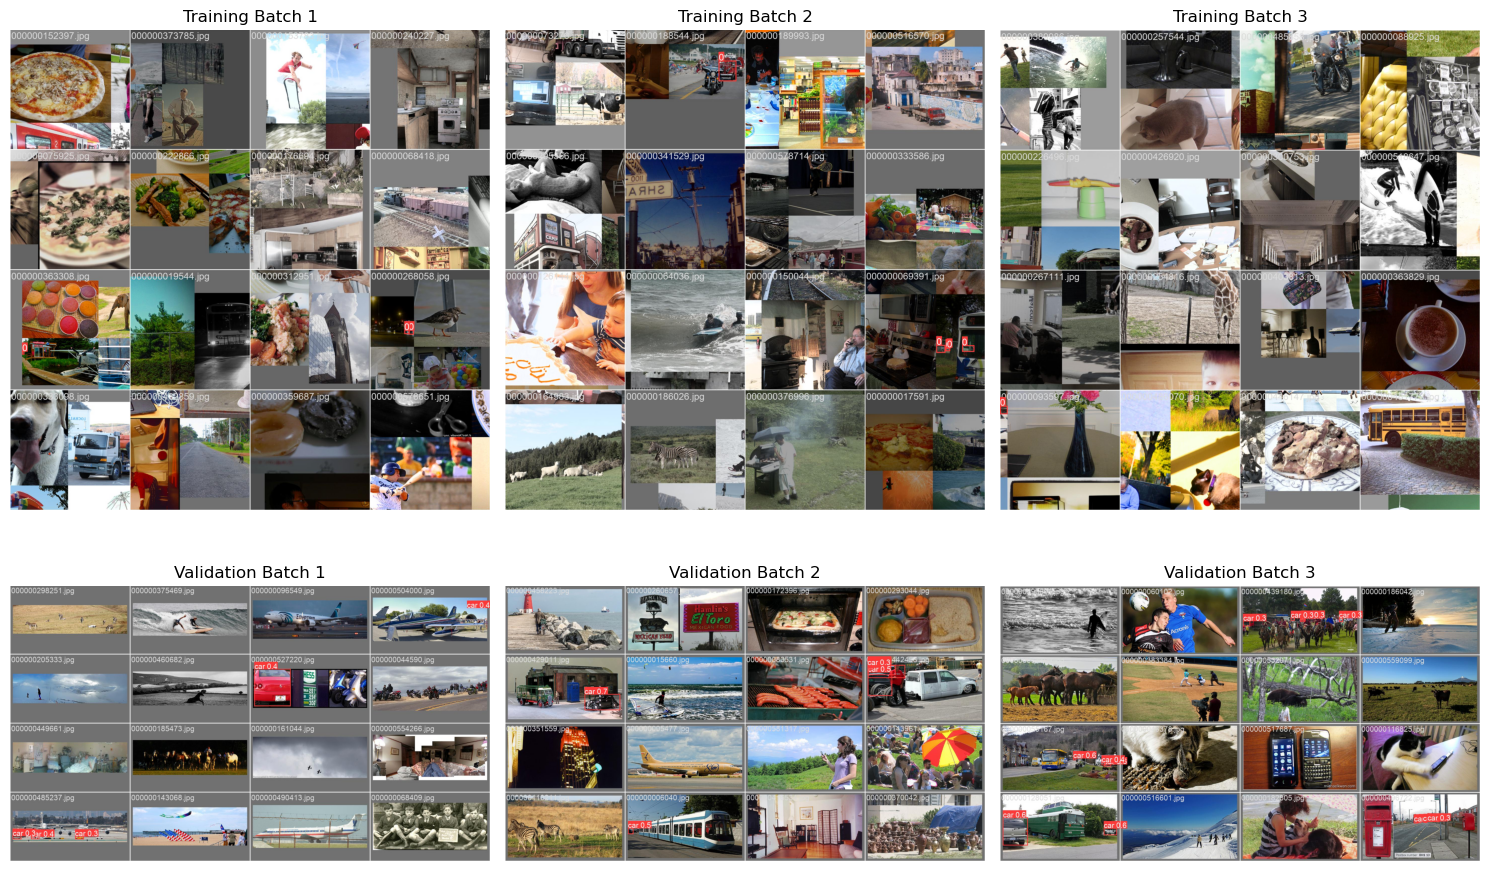

In [25]:
# Display Training Batch Predictions
train_img_paths = [
    "yolov5/runs/train/exp8/train_batch0.jpg",
    "yolov5/runs/train/exp8/train_batch1.jpg",
    "yolov5/runs/train/exp8/train_batch2.jpg",
]

# Display Validation Batch Predictions
val_img_paths = [
    "yolov5/runs/train/exp8/val_batch0_pred.jpg",
    "yolov5/runs/train/exp8/val_batch1_pred.jpg",
    "yolov5/runs/train/exp8/val_batch2_pred.jpg",
]

plt.figure(figsize=(15, 10))

# Training Batch Images
for i, path in enumerate(train_img_paths):
    img = Image.open(path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Training Batch {i+1}")

# Validation Batch Images
for i, path in enumerate(val_img_paths):
    img = Image.open(path)
    plt.subplot(2, 3, i + 4)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Validation Batch {i+1}")

plt.tight_layout()
plt.show()
